In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
%matplotlib inline

In [2]:
def visualize_images(input_images, num_cols, figure_name, cmap = None):
    "Shows input images by stacking them in num_cols columns"
    fig, axes = plt.subplots((int)((len(input_images) + 1) /num_cols), num_cols, figsize=(24, 20))

    fig = plt.gcf()
    fig.canvas.set_window_title(figure_name)
    
    print("Images for ", figure_name)
    
    for ax, image in zip(axes.flat, input_images):
        if(image.shape[2]==1):
            ax.imshow(image[:,:,0], cmap = cmap)
        else:
            ax.imshow(image, cmap=cmap)

    plt.show()

Read 8 images from ../data/test_images/ folder
Image shape =  (720, 1280, 3)
Images for  input_images


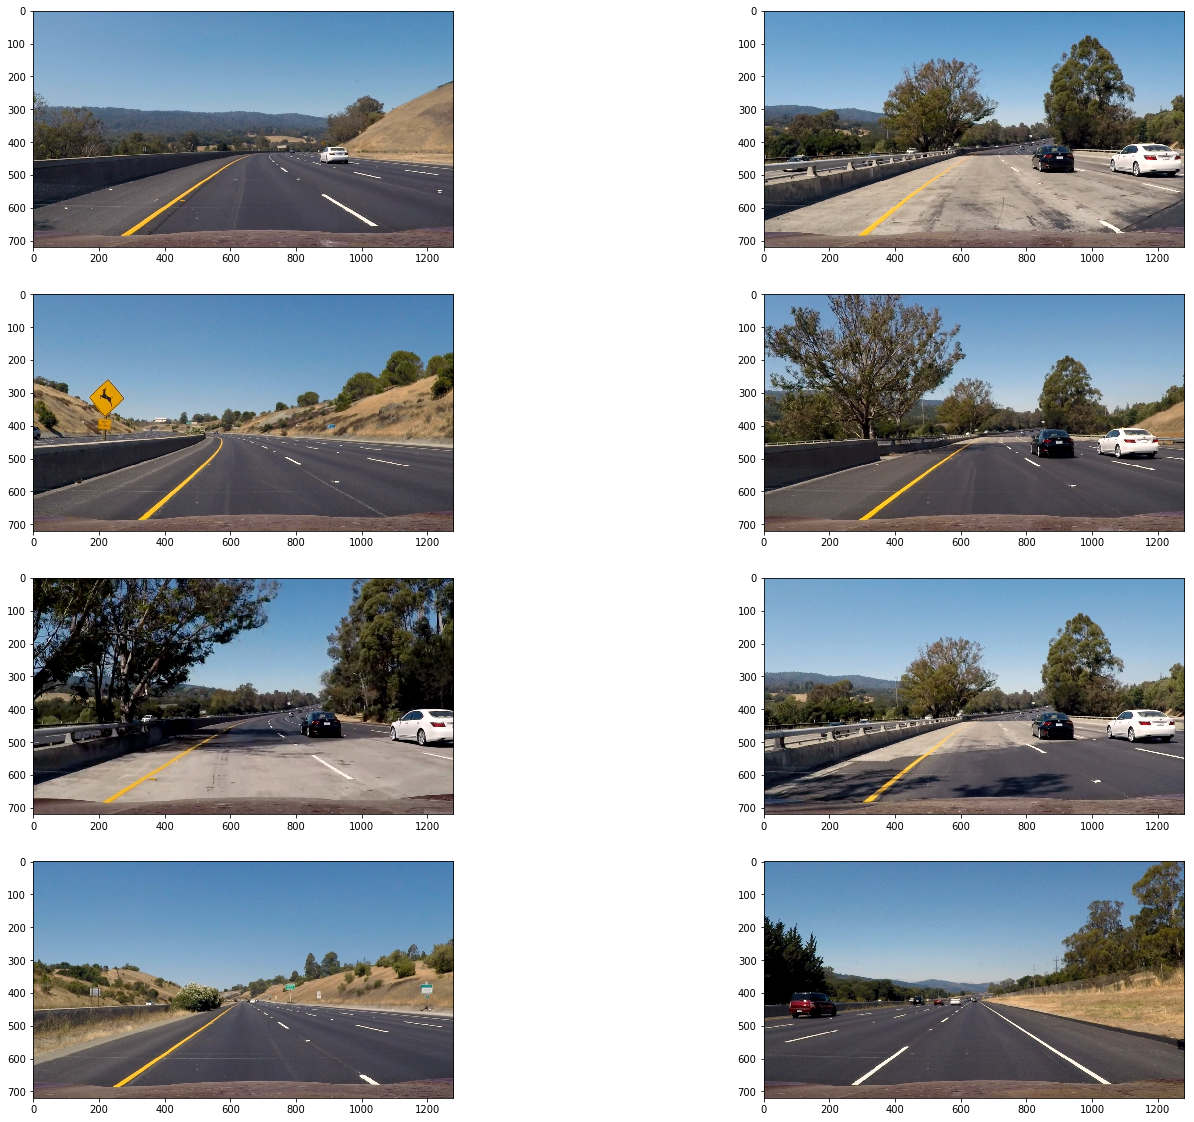

In [3]:
import glob

data_path = "../data/test_images/"

images_names = glob.glob(data_path + '*.jpg')
input_images = []

for idx, fname in enumerate(images_names):
    input_images.append(cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2RGB))

print("Read %d images from %s folder" % (len(images_names), data_path))

image_shape = input_images[0].shape
print("Image shape = ", image_shape)
visualize_images(input_images, 2, "input_images")

Images for  undistorted images


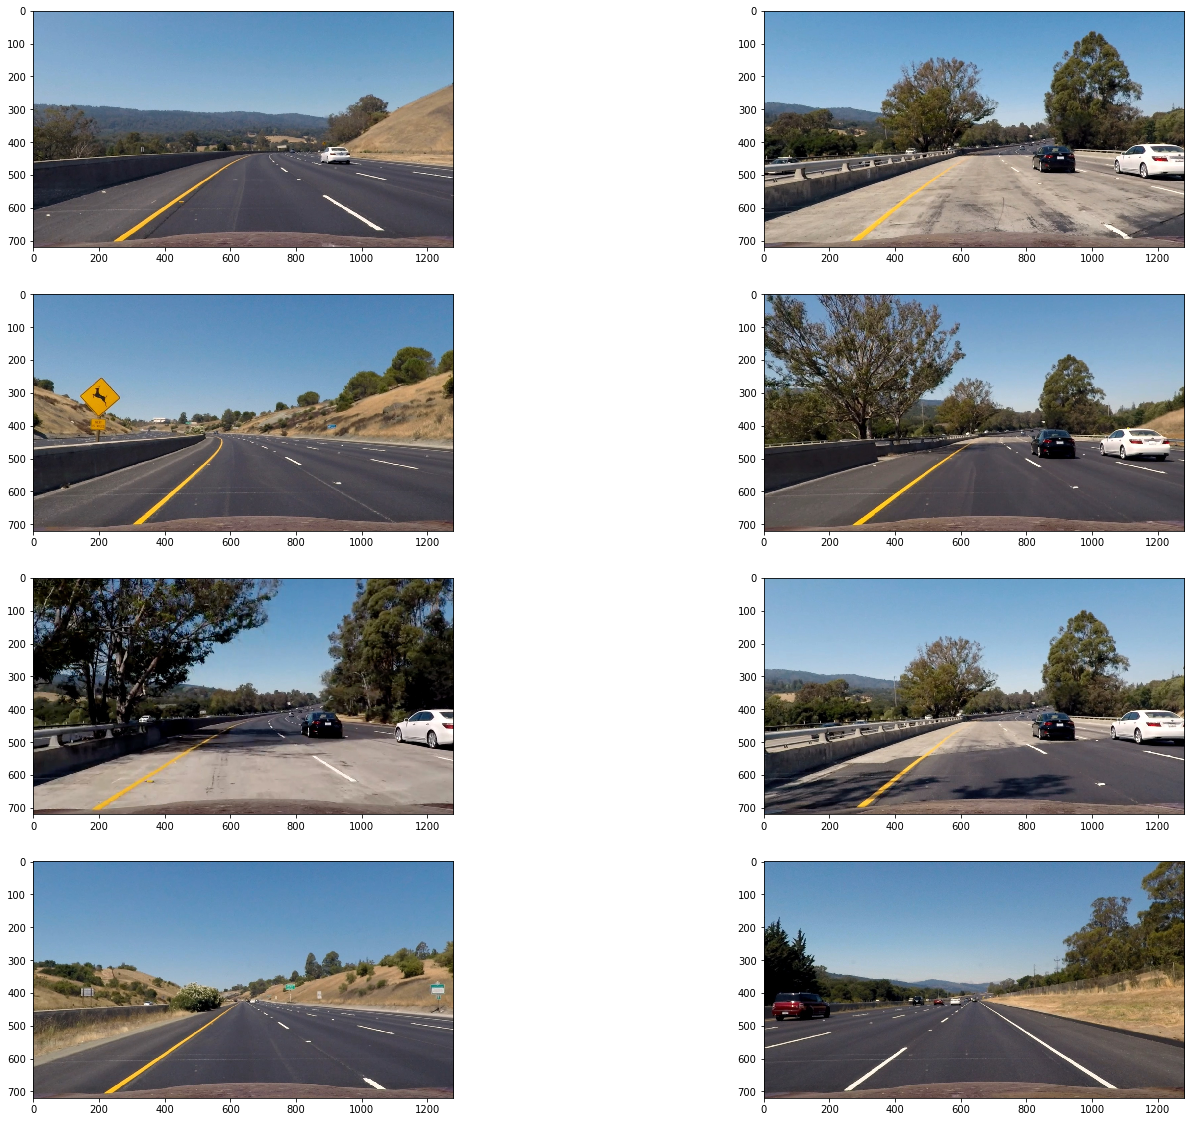

In [4]:
import pickle

camera_cal_file = "../results/camera_cal/camera_dist_pickle.p"

# Read in the saved objpoints and imgpoints
cal_pickle = pickle.load( open(camera_cal_file, "rb" ) )
mtx = cal_pickle["mtx"]
dist = cal_pickle["dist"]

undistorted_images = []
for image in input_images:
    undistorted_images.append(cv2.undistort(image, mtx, dist, None, mtx))

visualize_images(undistorted_images, 2, "undistorted images")

In [5]:
def color_binary_image(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    return color_binary
    

In [6]:
color_binary_images = np.zeros_like(undistorted_images)
for index, image in enumerate(undistorted_images):
    color_binary_images[index] = color_binary_image(image) 

Images for  color binary images


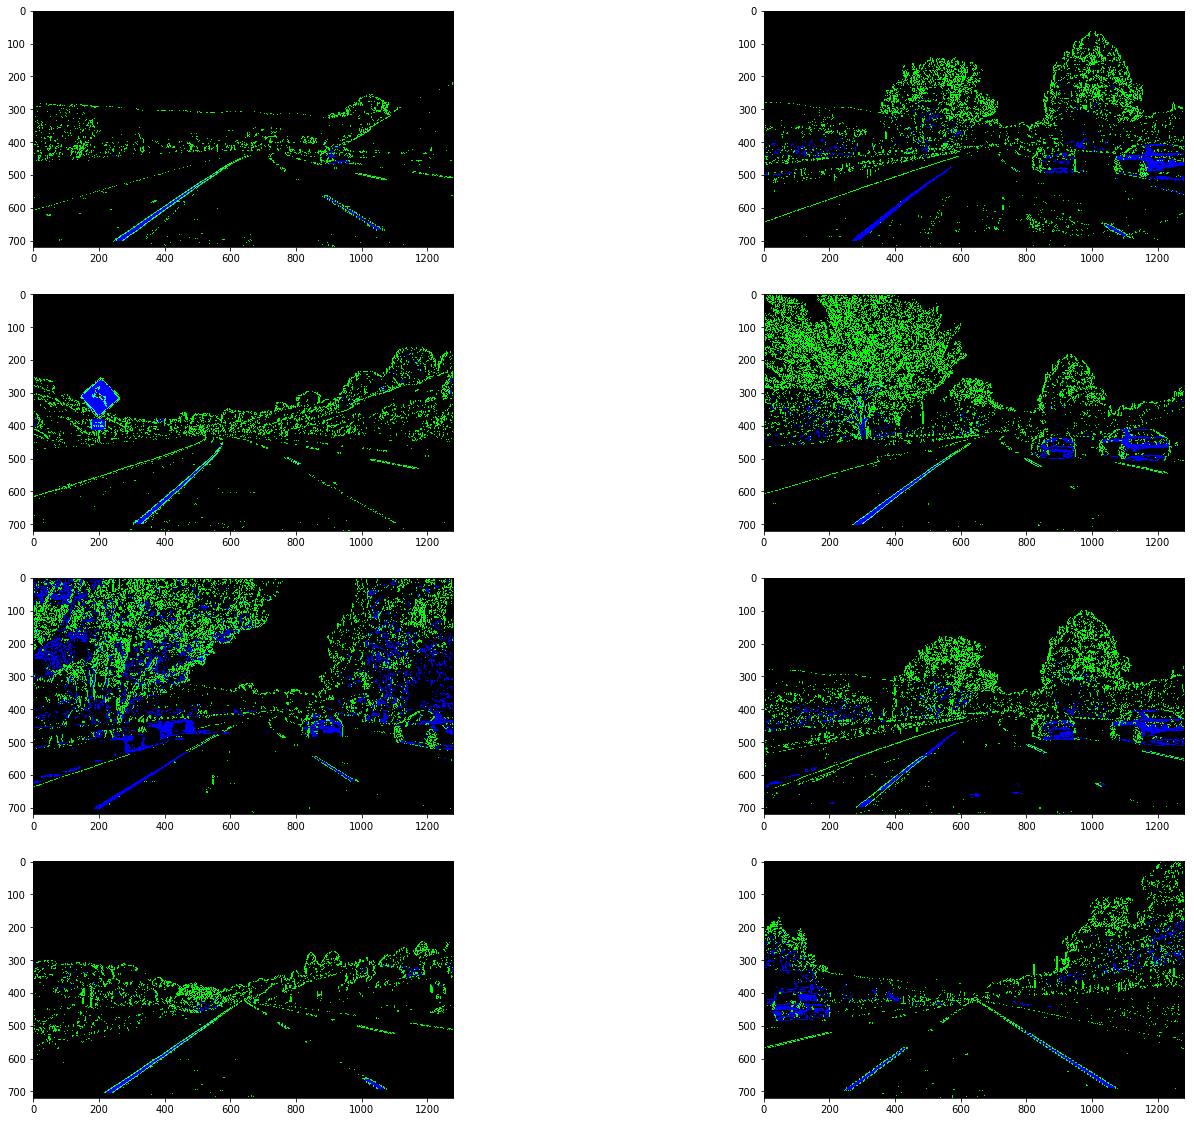

In [7]:
visualize_images(color_binary_images, 2, "color binary images")

In [8]:
src_vertices_roi = np.float32([(575, 460), (190 ,image_shape[0]), (1125, image_shape[0]), (710, 460)])
offset = 190
dst_vertices_roi = np.float32([[offset, 0], [offset, image_shape[0]], 
                                     [image_shape[1]-offset, image_shape[0]], 
                                     [image_shape[1]-offset, 0]])
print("src vertices = ", src_vertices_roi)
print("dst_vertices = ", dst_vertices_roi)

src vertices =  [[  575.   460.]
 [  190.   720.]
 [ 1125.   720.]
 [  710.   460.]]
dst_vertices =  [[  190.     0.]
 [  190.   720.]
 [ 1090.   720.]
 [ 1090.     0.]]


Images for  perspective transformed images


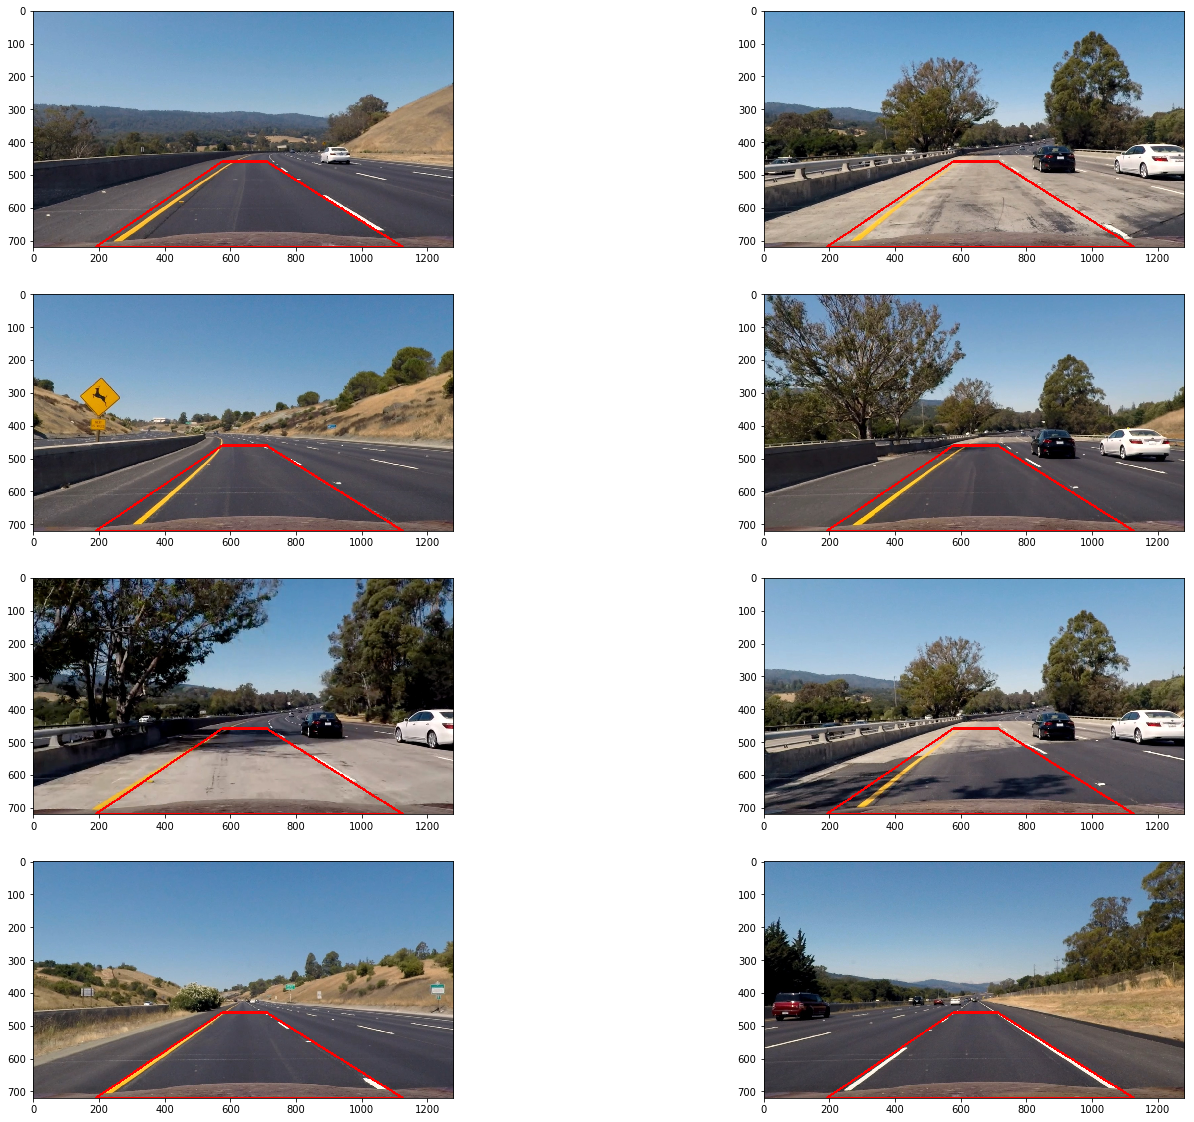

In [9]:
vis_roi = np.copy(undistorted_images)
for index, image in enumerate(vis_roi):
    cv2.polylines(image,[src_vertices_roi.reshape(-1,1,2).astype(int)], True,
                                   color = (255,0,0), thickness=5)
visualize_images(vis_roi, 2, "perspective transformed images")

In [10]:
def perspective_transform(img, src_vertices, dst_vertices):
    M = cv2.getPerspectiveTransform(src_vertices, dst_vertices)
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))
    return warped, M


In [12]:
ptransformed_images = np.zeros_like(color_binary_images)
ptransformed_M_inv = []
from numpy.linalg import inv
for index, image in enumerate(color_binary_images):
    ptransformed_images[index], perspective_M = perspective_transform(image, src_vertices_roi, dst_vertices_roi) 
    ptransformed_M_inv.append(inv(perspective_M))

Images for  perspective transformed images


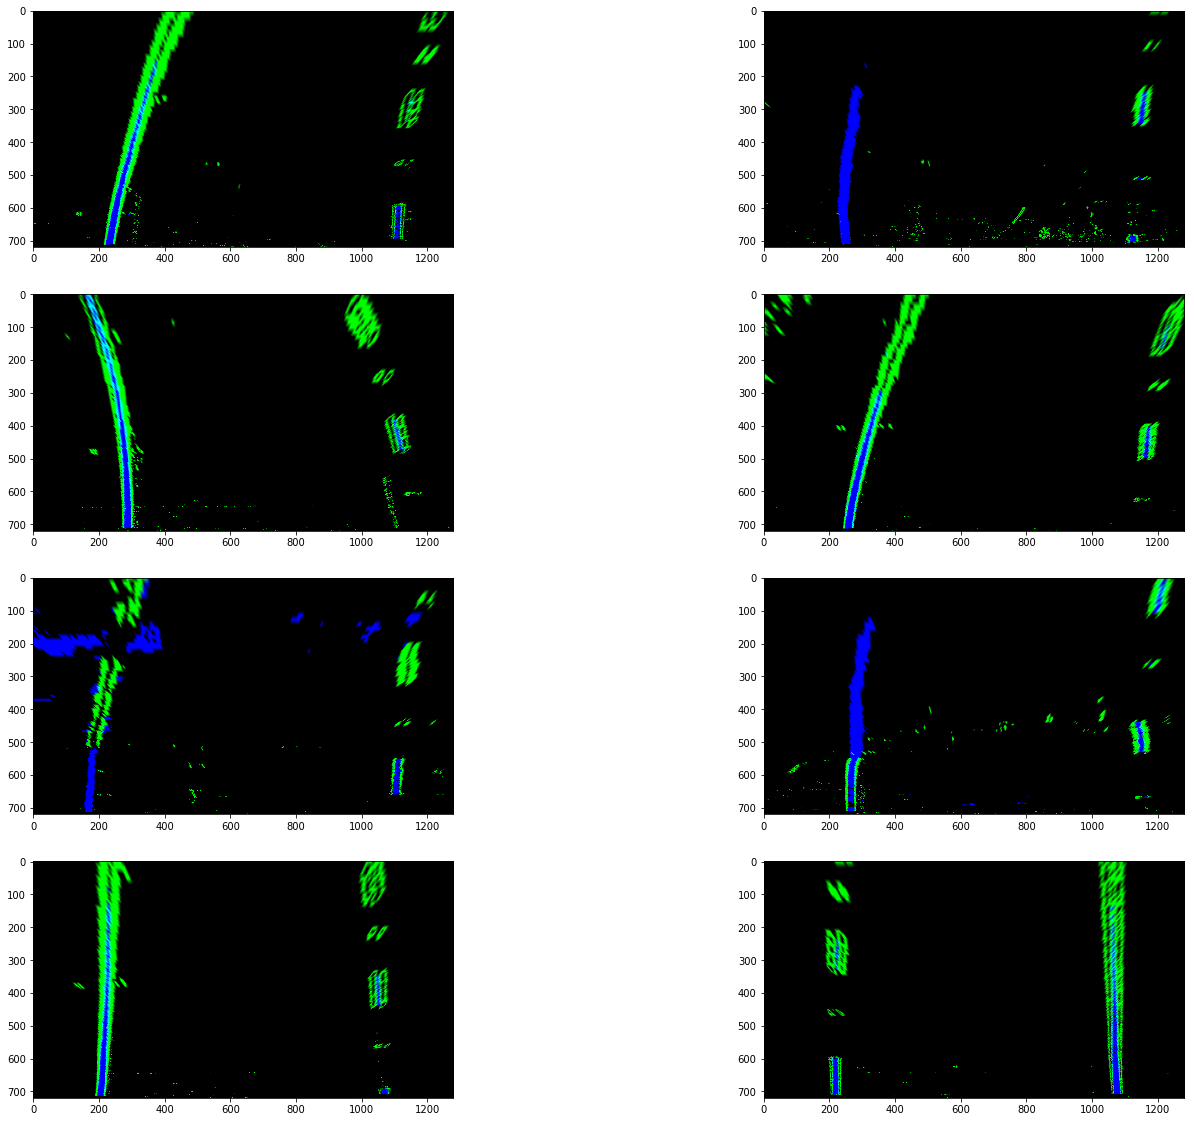

In [13]:
ptransformed_M_inv = np.asarray(ptransformed_M_inv)

visualize_images(ptransformed_images, 2, "perspective transformed images")

In [14]:
ptransformed_undist_images = np.zeros_like(undistorted_images)
for index, image in enumerate(undistorted_images):
    ptransformed_undist_images[index], perspective_M = perspective_transform(image, src_vertices_roi, dst_vertices_roi) 

Images for  perspective transformed images


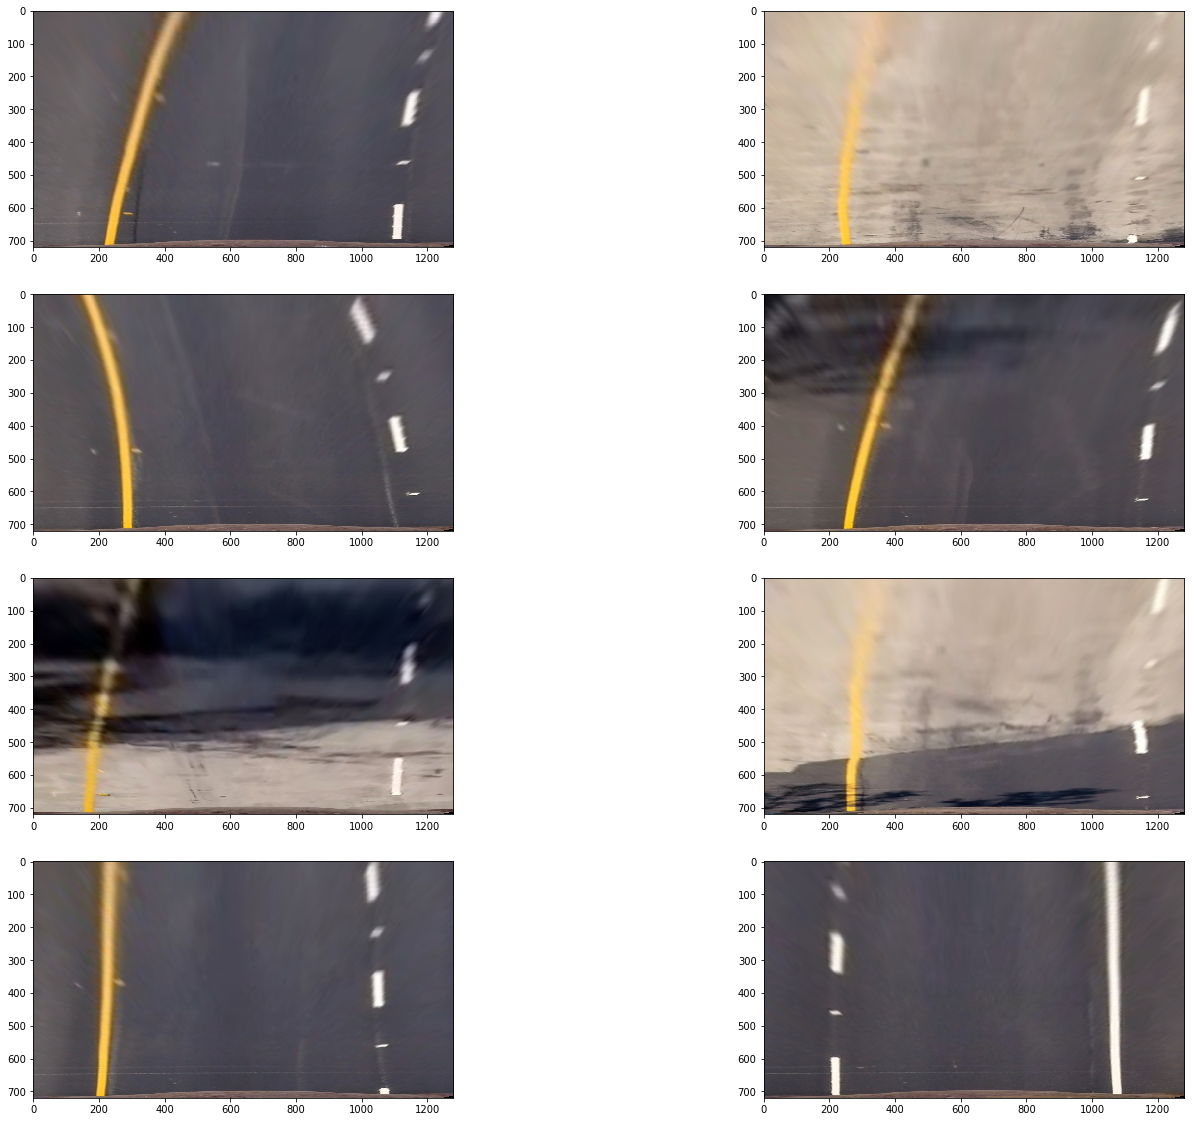

In [15]:
visualize_images(ptransformed_undist_images, 2, "perspective transformed images")

In [16]:
black_binary_images = np.zeros([ptransformed_images.shape[0], ptransformed_images.shape[1], 
                                ptransformed_images.shape[2], 1])
for index, image in enumerate(ptransformed_images):
    black_binary_images[index] = (image[:, : ,1] | image[:, :, 2]).reshape(ptransformed_images.shape[1], ptransformed_images.shape[2], 1)

Images for  binary perspective transformed images


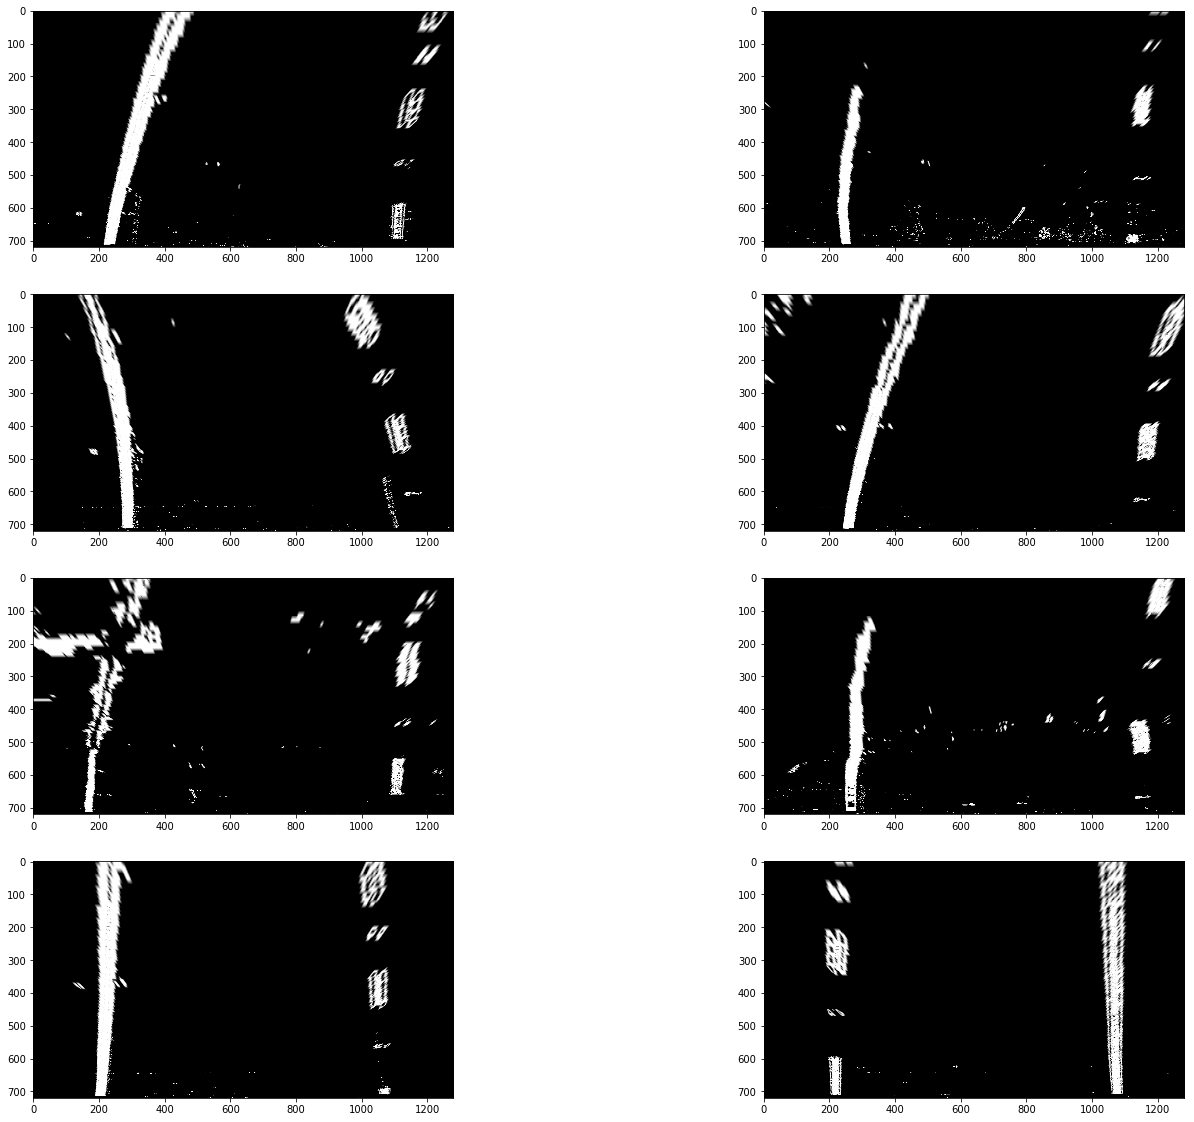

In [17]:
visualize_images(black_binary_images, 2, "binary perspective transformed images",cmap='Greys_r')

In [18]:
print(black_binary_images.shape)

(8, 720, 1280, 1)


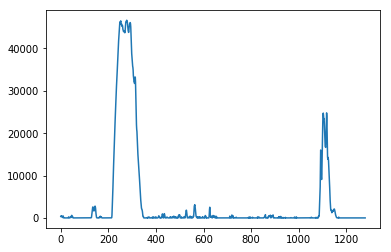

In [19]:
histogram = np.sum(black_binary_images[0][black_binary_images[0].shape[0]//2:,:], axis=0)
plt.plot(histogram)

In [20]:
print(histogram.shape)

(1280, 1)


In [21]:
def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    nonzero_left_indices = []
    nonzero_right_indices = []
    
    #To get the left and right points
    l_points = np.zeros_like(image)
    r_points = np.zeros_like(image)
    l_mask = window_mask(window_width,window_height,image,l_center,0)
    r_mask = window_mask(window_width,window_height,image,r_center,0)
    l_points[(image == 1) & ((l_mask == 1) ) ] = 255
    r_points[(image == 1) & ((r_mask == 1) ) ] = 255
    left_x, left_y = l_points.nonzero()
    nonzero_left_indices.append((left_x, left_y))
    right_x, right_y = r_points.nonzero()
    nonzero_right_indices.append((right_x, right_y))
    
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,image.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,image.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))
        #To get the left and right points
        l_mask = window_mask(window_width,window_height,image,l_center,level)
        r_mask = window_mask(window_width,window_height,image,r_center,level)
        l_points[(image == 1) & ((l_mask == 1) ) ] = 255
        r_points[(image == 1) & ((r_mask == 1) ) ] = 255
        left_x, left_y = l_points.nonzero()
        nonzero_left_indices.append((left_x, left_y))
        right_x, right_y = r_points.nonzero()
        nonzero_right_indices.append((right_x, right_y))

    return window_centroids, nonzero_left_indices, nonzero_right_indices

In [22]:
def visualize_window_centroids(image, window_centroids, window_width, window_height):
    # If we found any window centers
    if len(window_centroids) > 0:

        # Points used to draw all the left and right windows
        l_points = np.zeros_like(image)
        r_points = np.zeros_like(image)

        # Go through each level and draw the windows 	
        for level in range(0,len(window_centroids)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,image,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,image,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channel
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        warpage = np.array(cv2.merge((image,image,image)),np.uint8) # making the original road pixels 3 color channels
        output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results

    # If no window centers found, just display orginal road image
    else:
        output = np.array(cv2.merge((image,image,image)),np.uint8)
        
    return output


In [23]:
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

window_centroids_results = []
left_centroids_indices = []
right_centroids_indices = []
window_centroids_images = np.zeros_like(color_binary_images)
for index, image in enumerate(black_binary_images):
    window_centroids, left_points, right_points = find_window_centroids(image[:,:, 0]/255, window_width, window_height, margin)
    window_centroids_results.append(window_centroids)
    left_centroids_indices.append(left_points)
    right_centroids_indices.append(right_points)
    window_centroids_images[index] = visualize_window_centroids(image, window_centroids, window_width, window_height)



Images for  window centroids


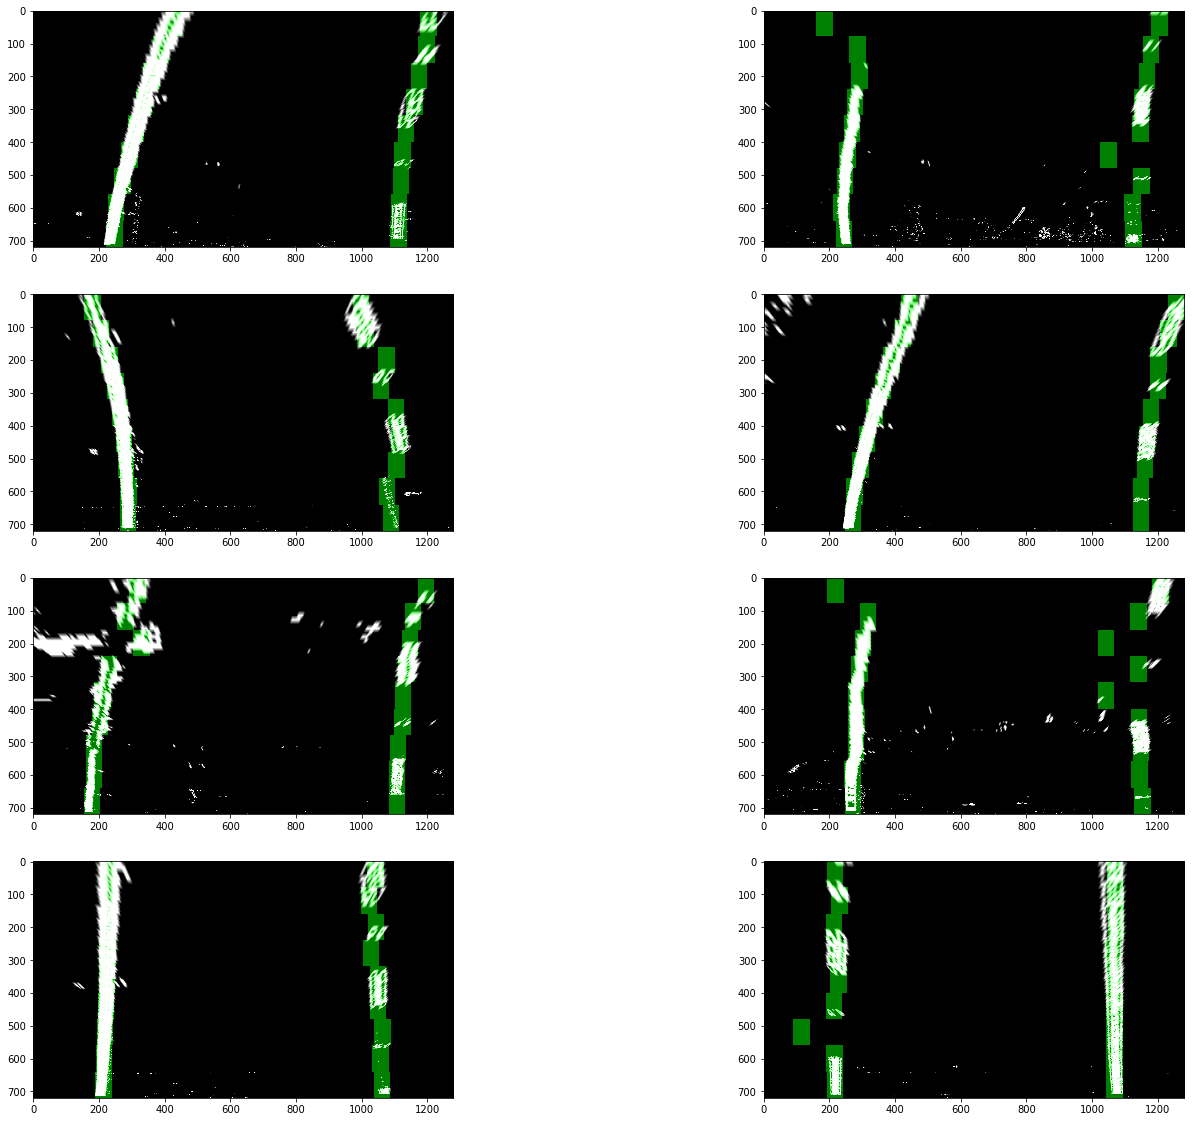

In [24]:
visualize_images(window_centroids_images, 2, "window centroids")

In [25]:
window_centroids_results = np.asarray(window_centroids_results)
print(window_centroids_results.shape)

(8, 9, 2)


In [26]:
left_centroids_indices = np.asarray(left_centroids_indices)
right_centroids_indices = np.asarray(right_centroids_indices)

In [27]:
print(left_centroids_indices[1][1])
print(right_centroids_indices.shape)

[array([560, 560, 560, ..., 711, 711, 711])
 array([229, 230, 231, ..., 250, 251, 252])]
(8, 9, 2)


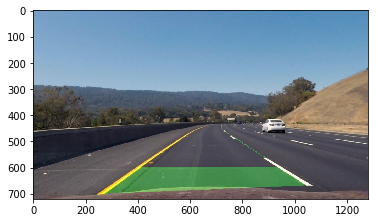

In [29]:
ploty = [y for y in range(0, )]
for left_centroids, right_centroids, image in zip(left_centroids_indices, right_centroids_indices, black_binary_images):
    # Fit a second order polynomial to pixel positions in each fake lane line
    leftx = np.concatenate(left_centroids[:,1], axis = 0)
    lefty = np.concatenate(left_centroids[:,0], axis = 0)
    
    rightx = np.concatenate(right_centroids[:,1], axis = 0)
    righty = np.concatenate(right_centroids[:,0], axis = 0)
    
    left_fit = np.polyfit(lefty, leftx, 2)
    left_fitx = left_fit[0]*lefty**2 + left_fit[1]*lefty + left_fit[2]
    right_fit = np.polyfit(righty, rightx, 2)
    right_fitx = right_fit[0]*righty**2 + right_fit[1]*righty + right_fit[2]
    
    mark_size = 3
    
    warp_zero = np.zeros_like(image).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, lefty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, righty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, ptransformed_M_inv[0], (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted_images[0], 1, newwarp, 0.3, 0)
    plt.imshow(result)
    break
    
#     fig = plt.plot(leftx, lefty, 'o', color='red', markersize=mark_size)
#     plt.plot(rightx, righty, 'o', color='blue', markersize=mark_size)
#     plt.xlim(0, 1280)
#     plt.ylim(0, 720)
#     plt.plot(left_fitx, lefty, color='green', linewidth=3)
#     plt.plot(right_fitx, righty, color='green', linewidth=3)
#     plt.gca().invert_yaxis() # to visualize as we do the images
  


In [ ]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(undistorted_images[0]).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, lefty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, righty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
plt.imshow(result)